# Who has heart diseases?
This [heart disease dataset](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) is from the UC Irvine Machine Learning Repository. It has 14 attributes, including the presence of heart disease in each patient (absence: 0; presence: 1, 2, 3, 4). Here I will use k-means to cluster patients into different groups and compare results to the "ground truth".

## Prepare data

In [1]:
# Import libraries
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics

### Load data

In [2]:
# DB credentials
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "heartdisease"

# Get table
engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

raw = pd.read_sql_query("select * from heartdisease", con=engine)

engine.dispose()

In [3]:
# Inspect first few rows
raw.head()

0    1    2      3      4    5    6      7    8    9   10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0

### Missing values
Let's first check for missing values.

In [4]:
# Write a function to display columns with missing values
def check_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing = pd.concat([total, percent], axis=1, keys=["total", "percent"])
    missing = missing.loc[missing["total"] > 0, :]
    return missing

In [5]:
# Check our data
check_missing(raw)

Empty DataFrame
Columns: [total, percent]
Index: []

There doesn't seem to be any missing values in this dataset. Upon closer look, missing values are labeled by "?". Let's replace it with `None` and check for missing values again.

In [6]:
# Create a new data frame
df = raw.copy()
# Replace "?" with None
df.replace({"?": None}, inplace=True)

In [7]:
check_missing(df)

total   percent
11      4  0.013201
12      2  0.006601

Since there are only a few missing values, we can drop rows with them.

In [8]:
df = df.dropna()

### Feature engineering
Since there are only 14 features, simple engineering would suffice.

In [9]:
# Features
X = df.iloc[:, :13]
# Target
y = df.iloc[:, 13]
# Recode outcomes into diagnosis (0) vs. no diagnosis (> 0)
y = np.where(y > 0, 1, 0)

Since K-means clustering is "isotropic" in all directions, it's critical to standardize the features to make sure that have comparable units (see this suggestion on [Cross Validated](https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering)).

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## K-means clustering
We know in advance that there should be two clusters of patients: Those with or without heart disease. However, k-means clustering cannot "see" how many clusters there are or which patient belongs to which cluster. So let's try k = 2, 3, 4 and see for each k value, whether the algorithm clusters patients **consistently** (same cases are put into the same cluster across different runs) and **accurately** (close to "ground truth" or having higher within-cluster similarity than between-cluster similarity).

### Consistency
We can split the dataset in half and check if clusters found by k-means are consistent between them.

In [11]:
# Split dataset in half
X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=123)

To visualize the clusters on a plane, we can decompose 13 features into 2 principal components.

In [12]:
pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(X_1)
X_pca2 = pca.fit_transform(X_2)

Then we can cluster based on the principal components.

In [13]:
# Function to store results in a dataframe
def cluster(X):
    y_pred = pd.DataFrame()
    for k in range(2, 5):
        y_pred[str(k) + "clusters"] = KMeans(
            n_clusters=k, random_state=123
        ).fit_predict(X)
    return y_pred


# Predictions for first subset
y_pred1 = cluster(X_pca1)

# Predictions for second subset 
y_pred2 = cluster(X_pca2)

Finally, let's visualize the results. 

In [14]:
# Put features together 
features = [X_pca1, X_pca2]

# Put predictions together
predictions = [y_pred1, y_pred2]

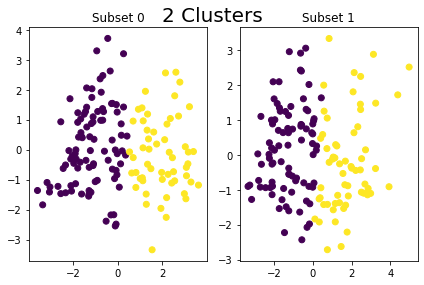

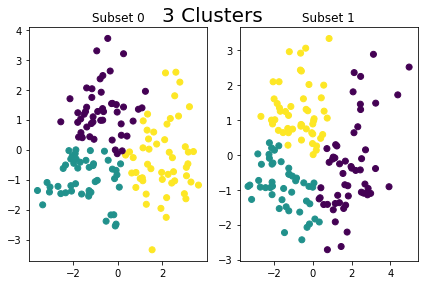

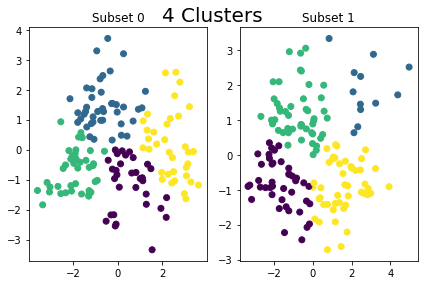

In [15]:
# Visualize clusters in 2D
for k in range(2, 5):

    # Make a grid of each subplot
    f, ax = plt.subplots(1, 2)

    # Make a plot for each subset
    for i in range(2):

        # Principal components
        pc_1 = features[i][:, 0]  # First
        pc_2 = features[i][:, 1]  # Second

        # Cluster assignments
        c = predictions[i][str(k) + "clusters"]

        # Assign the subplot to its place on the grid.
        ax[i].scatter(pc_1, pc_2, c=c, cmap='viridis')
        ax[i].set_title("Subset {}".format(i))

    # Space out the plots so that the headings don't overlap axis values
    plt.suptitle("{} Clusters".format(k), fontsize=20)
    plt.tight_layout()
    plt.show()
    print("\n")

We can ignore the colors since they are arbitrarily assigned to the clusters. As we can see, cluster assignments are the most consistent across subsets when k = 2 and less so when k = 3 or 4.

### Accuracy (ARI)
We know which cluster each patient actually belongs to. We use Adjusted Rand Index (ARI) to measure the accuracy of cluster assignments compared to the "ground truth". This time, let's use the entire dataset with all 13 features.

In [16]:
for col in cluster(X).columns:
    ari = metrics.adjusted_rand_score(y, cluster(X)[col])
    print("ARI for {}: {}.".format(col, ari))

ARI for 2clusters: 0.4379944036207641.
ARI for 3clusters: 0.27562087416855585.
ARI for 4clusters: 0.21169405874869324.


ARI is also the highest when we use 2 clusters. However, even then the results are no better than chance (0.5).

### Similarity (silhouette coefficient)
Pretend that we don't know the true clusters, we can use the "[silhouette coefficient](https://en.wikipedia.org/wiki/Silhouette_(clustering))" to evaluate clusters predicted by k-means. The silhouette measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). High values (close to 1) indicate the object is well matched to its own cluster and poorly matched to neighboring clusters where low values (close to -1) the opposite.

In [17]:
for col in cluster(X).columns:
    silhouette = metrics.silhouette_score(X, cluster(X)[col])
    print("The silhouette for {}: {}.".format(col, silhouette))

The silhouette for 2clusters: 0.17511353215805028.
The silhouette for 3clusters: 0.12962074150189365.
The silhouette for 4clusters: 0.13196574421777463.


Again, the silhouette is the highest when k = 2 but far from 1 in all cases.

## Hierarchical clustering

## DBSCAN